## Import module and installation package

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
# be sure your API key file json copied to your drive google
results = drive_service.files().list(q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." %int(status.progress()*100))

os.chmod(filename, 600)

Download 100%.


In [0]:
import numpy as np
import pandas as pd

In [3]:
!pip install kaggle;
!pip install lightgbm;
!pip install xgboost;

In [0]:
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import power_transform

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [0]:
import lightgbm as lgb
import xgboost as xgb

In [0]:
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor


In [8]:
# download output file from kernel
!kaggle kernels output nyc-taxi-duration-eda-by-nguyen-khac-bao-anh

Output file downloaded to /content/testing_data.csv
Output file downloaded to /content/training_data.csv
Kernel log downloaded to /content/nyc-taxi-duration-eda-by-nguyen-khac-bao-anh.log 


## Data reading

In [0]:
## read data
train = pd.read_csv('training_data.csv')
test = pd.read_csv('testing_data.csv')

### Imputation missing value

In [10]:
# all colonnes that have missing value in training set and testing set
col_have_nan = list(set(train.columns[train.isna().sum() != 0]).union(set(test.columns[test.isna().sum() != 0])))
col_have_nan

['Temp.', 'ave_speed_x', 'ave_speed_y']

In [0]:
for c in col_have_nan:
    train[c].fillna(train[c].mean(), inplace=True)
    test[c].fillna(train[c].mean(), inplace=True)

In [0]:
xtrain = train.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'log_trip_duration'], axis=1)
xtest = test.drop(['id', 'pickup_datetime'], axis=1)
y = train.trip_duration.values
id_test = test.id.values

In [13]:
xtrain.shape, xtest.shape

((1458644, 21), (625134, 21))

#### Setup for all data like cox-box transform

In [0]:
#ntrain = train.shape[0]
#ntest = test.shape[0]
#id_test = test.id.values
#y = train.log_trip_duration.values
#all_data = pd.concat([train, test])
#all_data.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'log_trip_duration'], axis=1, inplace=True)
#del(train, test)
#print("all_data size is : {}".format(all_data.shape))

all_data size is : (2083778, 21)


In [0]:
#all_data.head()

,0_x,0_y,Temp.,ave_speed_x,ave_speed_y,day,dayofweek,dist,dist_lat,dist_long,...,dropoff_longitude,hour,minute,month,passenger_count,pickup_latitude,pickup_longitude,store_and_fwd_flag,vendor_id,weekday
0,68221,72764,4.4,3.610834,3.898475,14,0,0.017680,0.002335,-0.017525,...,-73.964630,17,24,3,1,40.767937,-73.982155,0,2,0
1,59478,51890,28.9,3.855183,3.548049,12,6,0.020456,0.007412,0.019066,...,-73.999481,0,43,6,1,40.738564,-73.980415,0,1,6
2,111200,38071,-6.7,3.474121,4.320430,19,1,0.059934,0.053852,0.026306,...,-74.005333,11,35,1,1,40.763939,-73.979027,0,2,1
3,29991,38071,7.2,4.085823,4.320430,6,2,0.013438,0.013252,0.002228,...,-74.012268,19,32,4,1,40.719971,-74.010040,0,2,2
4,36415,11401,9.4,4.407767,4.054702,26,5,0.010690,0.010689,-0.000130,...,-73.972923,13,30,3,1,40.793209,-73.973053,0,2,5


#### Analysis target: trip_duration

#### Trip duration

In [0]:
Y_transform = train.trip_duration.values

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")



 mu = 959.49 and sigma = 5237.43



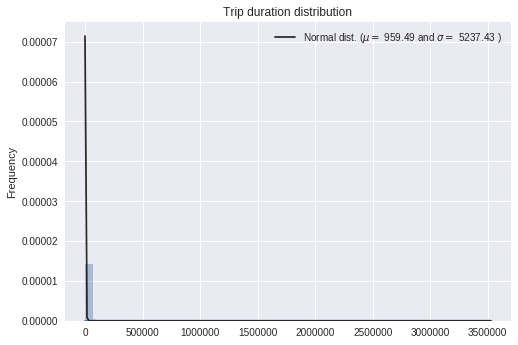

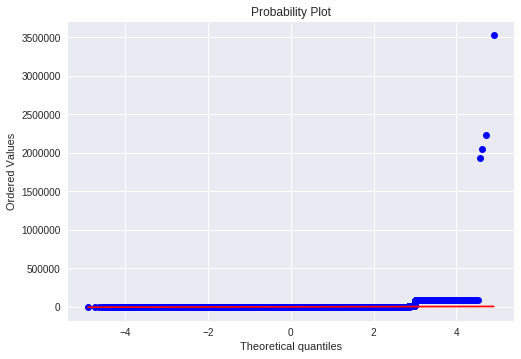

In [0]:
sns.distplot(Y_transform , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Y_transform)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Trip duration distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Y_transform, plot=plt)
plt.show()

#### Trip duration in log transform

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")



 mu = 6.47 and sigma = 0.80



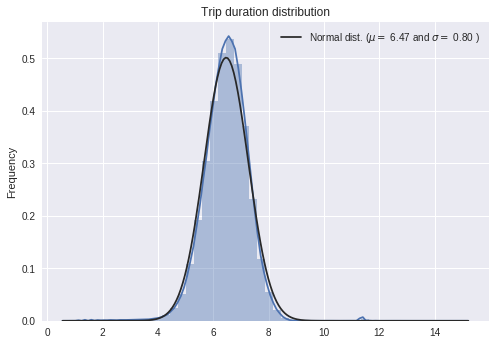

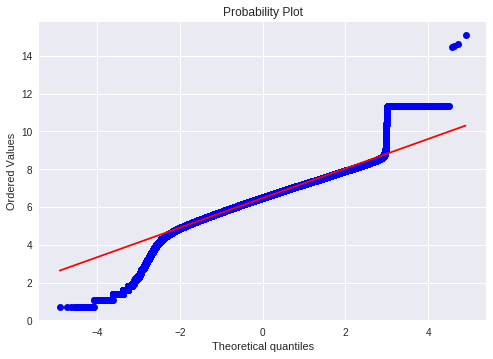

In [0]:
Y_transform = np.log1p(train.trip_duration.values)
sns.distplot(Y_transform , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Y_transform)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Trip duration distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Y_transform, plot=plt)
plt.show()

#### Cox-box transformation

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")



 mu = 6.36 and sigma = 0.77



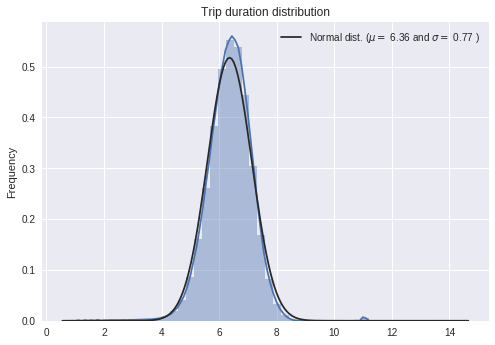

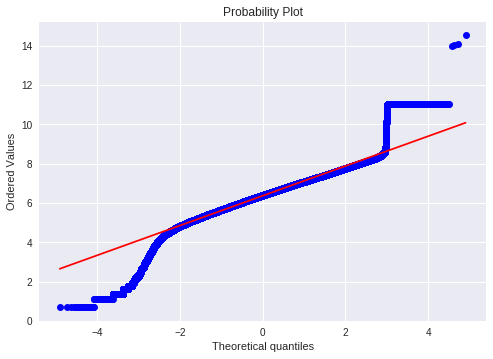

In [0]:
from scipy.special import boxcox1p
lam = -0.005
Y_transform = boxcox1p(train.trip_duration.values, lam)
sns.distplot(Y_transform , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Y_transform)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Trip duration distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Y_transform, plot=plt)
plt.show()

#### Test skew of features

In [0]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
ave_speed_x,580.420795
ave_speed_y,469.961762
dist,26.288577
store_and_fwd_flag,13.364071
dist_lat,8.370125
dist_long,5.257774
pickup_latitude,2.131394
passenger_count,2.130139
0_y,0.320090
0_x,0.244715


#### Box Cox Transformation of (highly) skewed features

In [0]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 21 skewed numerical features to Box Cox transform


In [0]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
store_and_fwd_flag,13.364071
dist,5.805183
ave_speed_x,3.396248
ave_speed_y,2.593857
passenger_count,1.832126
dist_long,0.770187
vendor_id,-0.140063
month,-0.339211
dayofweek,-0.499752
weekday,-0.499752


In [0]:
xtrain = all_data[:ntrain]
xtest = all_data[ntrain:]

### Split data

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(xtrain,np.log1p(y), test_size=0.5, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((729322, 21), (729322, 21), (729322,), (729322,))

### Metrics for validation

In [0]:
from sklearn.metrics import mean_squared_log_error
def rmsle(y, pred):
    return np.sqrt(mean_squared_log_error(y,pred))

## Using `Tree`


In [0]:
dtr = DecisionTreeRegressor(criterion="mse",max_depth=14, max_features=0.5, min_samples_split=0.5, random_state=42)
etr = ExtraTreeRegressor(criterion="mse",max_depth=14, max_features=0.5, min_samples_split=0.5, random_state=42)

In [0]:
dtr.fit(X_train,y_train)
etr.fit(X_train,y_train)

ExtraTreeRegressor(criterion='mse', max_depth=14, max_features=0.5,
          max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1,
          min_samples_split=0.5, min_weight_fraction_leaf=0.0,
          random_state=42, splitter='random')

In [0]:
y_pred_dtr = dtr.predict(X_valid)
y_pred_etr = etr.predict(X_valid)
print("rmsle for DTR: {} \n rmsle for ETR: {}".format(rmsle(y_valid, y_pred_dtr),rmsle(y_valid, y_pred_etr)))

rmsle for DTR: 0.08787277716383204 
 rmsle for ETR: 0.11349226885659831


In [0]:
dtr.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.61900474, 0.        ,
       0.38099526, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [0]:
etr.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.17384434, 0.82615566, 0.        , 0.        ,
       0.        ])

In [0]:
y_test_dtr = dtr.predict(xtest)
y_test_etr = etr.predict(xtest)

In [0]:
df_train = pd.DataFrame({'dtr':y_pred_dtr, 'etr':y_pred_etr})
df_test = pd.DataFrame({'dtr':y_test_dtr, 'etr':y_test_etr})

## Using ensemble

In [0]:
gbr = GradientBoostingRegressor(learning_rate=0.5, n_estimators=20,subsample=0.7, max_features=0.9)

In [0]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='ls', max_depth=3, max_features=0.9,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=20, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=0.7, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
y_pred_gbr = gbr.predict(X_valid)
y_test_gbr = gbr.predict(xtest)
print("rmsle for gbr: {} ".format(rmsle(y_valid, y_pred_gbr)))

rmsle for gbr: 0.06530280025903959 


In [0]:
df_train['gbr'] = y_pred_gbr
df_test['gbr'] = y_test_gbr

In [0]:
rfr = RandomForestRegressor(n_estimators=30)

In [0]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
y_pred_rfr = rfr.predict(X_valid)
y_test_rfr = rfr.predict(xtest)
print("rmsle for gbr: {} ".format(rmsle(y_valid, y_pred_rfr)))

rmsle for gbr: 0.06035590584753727 


In [0]:
df_train['rfr'] = y_pred_rfr
df_test['rfr'] = y_test_rfr

## Using LGBM

### Configuration of param LGBM

In [51]:
## lightgbm parameters
params = {
    'learning_rate': 0.05,
    'max_depth': 14,
    'num_leaves': 60, 
    'objective': 'regression',
    'metric': 'rmse',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    #'bagging_freq': 5,
    'max_bin': 200
}

## number of rounds
nrounds = 5000

## train model
print('Train model lightGBM...')
dtrain = lgb.Dataset(X_train.values, y_train, free_raw_data=False)
dvalid = lgb.Dataset(X_valid.values, y_valid, free_raw_data=False)

Train model lightGBM...


### LightGBM CV

In [18]:
lgb_cv = lgb.cv(params,dtrain,num_boost_round=nrounds,nfold=5,stratified=False,early_stopping_rounds=10,verbose_eval=50,seed=42)

[50]	cv_agg's rmse: 0.417905 + 0.00337436
[100]	cv_agg's rmse: 0.406702 + 0.00314053
[150]	cv_agg's rmse: 0.403358 + 0.00367757
[200]	cv_agg's rmse: 0.401216 + 0.0035845
[250]	cv_agg's rmse: 0.400056 + 0.00353109
[300]	cv_agg's rmse: 0.399117 + 0.00348621
[350]	cv_agg's rmse: 0.398548 + 0.00357466
[400]	cv_agg's rmse: 0.398356 + 0.00342817
[450]	cv_agg's rmse: 0.397991 + 0.00343204


### Traing model LGBM

In [52]:
evals_result={}
lgbm = lgb.train(params,
                dtrain,valid_sets=[dtrain,dvalid], evals_result=evals_result,verbose_eval=100,early_stopping_rounds=20,
                num_boost_round = nrounds)

Training until validation scores don't improve for 20 rounds.
[100]	training's rmse: 0.415009	valid_1's rmse: 0.414925
[200]	training's rmse: 0.398272	valid_1's rmse: 0.401908
[300]	training's rmse: 0.389952	valid_1's rmse: 0.397505
[400]	training's rmse: 0.383859	valid_1's rmse: 0.394756
[500]	training's rmse: 0.379011	valid_1's rmse: 0.392802
[600]	training's rmse: 0.374671	valid_1's rmse: 0.391131
[700]	training's rmse: 0.370879	valid_1's rmse: 0.389577
[800]	training's rmse: 0.367522	valid_1's rmse: 0.388647
[900]	training's rmse: 0.364739	valid_1's rmse: 0.387966
[1000]	training's rmse: 0.362032	valid_1's rmse: 0.387466
[1100]	training's rmse: 0.359493	valid_1's rmse: 0.386916
[1200]	training's rmse: 0.357054	valid_1's rmse: 0.386401
[1300]	training's rmse: 0.354856	valid_1's rmse: 0.385995
[1400]	training's rmse: 0.352621	valid_1's rmse: 0.38543
[1500]	training's rmse: 0.350534	valid_1's rmse: 0.385133
[1600]	training's rmse: 0.348434	valid_1's rmse: 0.384726
[1700]	training's rm

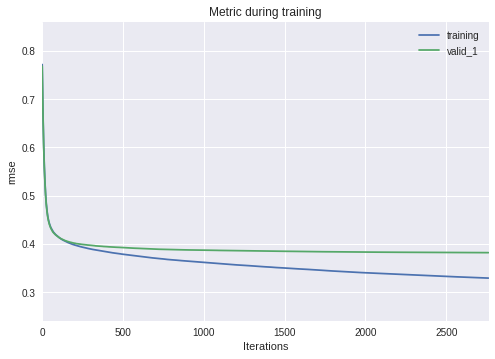

In [53]:
lgb.plot_metric(evals_result, metric='rmse')
plt.show()

#### config lgbm traing

In [83]:
evals_result={}
lgbm = lgb.train(params,
                dtrain,valid_sets=[dtrain,dvalid], evals_result=evals_result,verbose_eval=100,early_stopping_rounds=20,
                num_boost_round = 200)


Training until validation scores don't improve for 20 rounds.
[100]	training's rmse: 0.389483	valid_1's rmse: 0.39718
[200]	training's rmse: 0.383687	valid_1's rmse: 0.394272
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.383687	valid_1's rmse: 0.394272


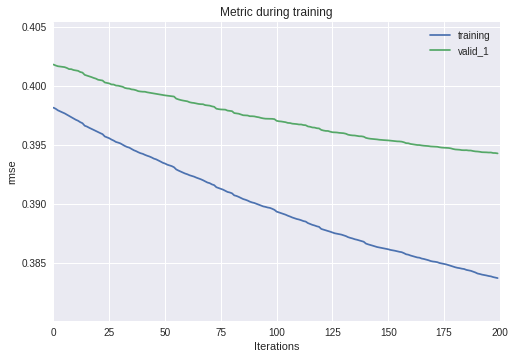

In [84]:
lgb.plot_metric(evals_result, metric='rmse')
plt.show()

##### save initiate model

In [0]:
lgbm.save_model("init_model.txt");

In [86]:
evals_result_1={}
lgbm = lgb.train(params,
                dtrain,
                init_model="init_model.txt",
                valid_sets=[dtrain,dvalid], 
                evals_result=evals_result_1,
                verbose_eval=100,
                early_stopping_rounds=20,
                num_boost_round = 200)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:814: UserWarning: The prediction of init_model will be overridden by init_score.
  warnings.warn("The prediction of init_model will be overridden by init_score.")


Training until validation scores don't improve for 20 rounds.
[300]	training's rmse: 0.389483	valid_1's rmse: 0.39718
[400]	training's rmse: 0.383687	valid_1's rmse: 0.394272
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.383687	valid_1's rmse: 0.394272


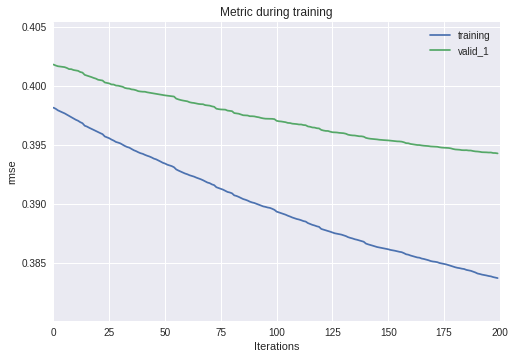

In [89]:
lgb.plot_metric(evals_result_1, metric='rmse')
plt.show()

##### changing parameter to deal with overfitting

In [90]:
evals_result_2={}
lgbm = lgb.train(params,
                dtrain,
                init_model="init_model.txt",
                valid_sets=[dtrain,dvalid], 
                evals_result=evals_result_2,
                verbose_eval=100,
                early_stopping_rounds=20,
                num_boost_round = 200,
                callbacks=[lgb.reset_parameter(max_bin=[100]*200),lgb.reset_parameter(num_leaves=[20]*200),lgb.reset_parameter(feature_fraction=[0.8]*100+[0.7]*100)])

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:814: UserWarning: The prediction of init_model will be overridden by init_score.
  warnings.warn("The prediction of init_model will be overridden by init_score.")


Training until validation scores don't improve for 20 rounds.
[300]	training's rmse: 0.39527	valid_1's rmse: 0.399903
[400]	training's rmse: 0.392728	valid_1's rmse: 0.398387
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.392728	valid_1's rmse: 0.398387


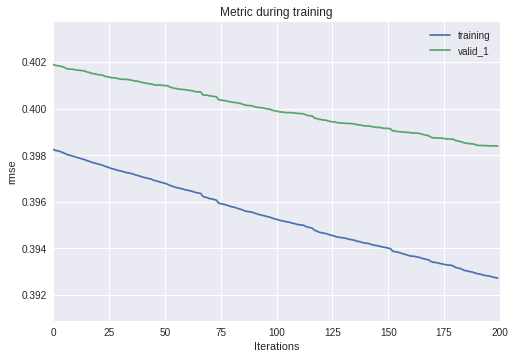

In [91]:
lgb.plot_metric(evals_result_2, metric='rmse')
plt.show()

In [95]:
evals_result_3={}
lgbm = lgb.train(params,
                dtrain,
                init_model="init_model.txt",
                valid_sets=[dtrain,dvalid], 
                evals_result=evals_result_3,
                verbose_eval=100,
                early_stopping_rounds=20,
                num_boost_round = 5000,
                callbacks=[lgb.reset_parameter(max_bin=[150]*5000),lgb.reset_parameter(num_leaves=[20]*5000),lgb.reset_parameter(feature_fraction=[0.8]*2500+[0.7]*2500)])

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:814: UserWarning: The prediction of init_model will be overridden by init_score.
  warnings.warn("The prediction of init_model will be overridden by init_score.")


Training until validation scores don't improve for 20 rounds.
[300]	training's rmse: 0.39527	valid_1's rmse: 0.399903
[400]	training's rmse: 0.392758	valid_1's rmse: 0.398385
[500]	training's rmse: 0.390566	valid_1's rmse: 0.397137
[600]	training's rmse: 0.388462	valid_1's rmse: 0.396092
[700]	training's rmse: 0.386496	valid_1's rmse: 0.395023
[800]	training's rmse: 0.384852	valid_1's rmse: 0.39434
[900]	training's rmse: 0.38319	valid_1's rmse: 0.393591
[1000]	training's rmse: 0.381689	valid_1's rmse: 0.39298
[1100]	training's rmse: 0.380395	valid_1's rmse: 0.392443
[1200]	training's rmse: 0.379211	valid_1's rmse: 0.391928
[1300]	training's rmse: 0.377888	valid_1's rmse: 0.391364
[1400]	training's rmse: 0.37668	valid_1's rmse: 0.390966
[1500]	training's rmse: 0.375544	valid_1's rmse: 0.390519
[1600]	training's rmse: 0.37443	valid_1's rmse: 0.390286
[1700]	training's rmse: 0.37338	valid_1's rmse: 0.389906
[1800]	training's rmse: 0.372435	valid_1's rmse: 0.389559
[1900]	training's rmse: 

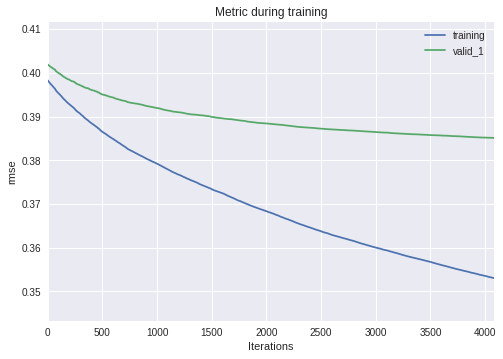

In [96]:
lgb.plot_metric(evals_result_3, metric='rmse')
plt.show()

In [103]:
best_iter = lgbm.best_iteration
best_iter

4264

#### Training all of data

In [0]:
l_gbm = lgb.train(params,
                lgb.Dataset(xtrain,np.log1p(y)),
                num_boost_round = 5000,
                callbacks=[lgb.reset_parameter(max_bin=[200]*200+[150]*4800),lgb.reset_parameter(num_leaves=[60]*200+[20]*4800),lgb.reset_parameter(feature_fraction=[0.9]*200+[0.8]*2400+[0.7]*2400)])

### Predicting

In [106]:
## predict valid
y_pred_lgbm = l_gbm.predict(X_valid)
y_test_lgbm = l_gbm.predict(xtest)
print("rmsle for gbr: {} ".format(rmsle(np.expm1(y_valid), np.expm1(y_pred_lgbm))))

rmsle for gbr: 0.35704091189826725 


In [0]:
df_train['lgbm'] = y_pred_lgbm
df_test['lgbm'] = y_test_lgbm

In [0]:
## test predictions
pred_test = np.expm1(y_test_lgbm)

## create submission
df = pd.DataFrame({'id': id_test, 'trip_duration': pred_test}) 
df = df.set_index('id')
df.to_csv('sub_lgbm.csv', index = True)
del(df,pred_test)

In [108]:
# submit file
!kaggle competitions submit -c nyc-taxi-trip-duration -f sub_lgbm.csv -m "submission by LGBM , increase num_iter and descrease eta"

100% 16.9M/16.9M [00:11<00:00, 1.54MB/s]
Successfully submitted to New York City Taxi Trip Duration

## XGBoost

### Configuration param of XGB

In [0]:
## xgb parameters
params_xgb = {
    'booster':            'gbtree',
    'objective':          'reg:linear',
    'learning_rate':      0.01,
    'max_depth':          14,
    'subsample':          0.8,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1
}

## number of rounds
nrounds = 300

### Training model

In [0]:
## train model
print('Train model XGBOOST...')
dtrain = xgb.DMatrix(xtrain, y)
xgbm = xgb.train(params_xgb,
                dtrain,
                num_boost_round = nrounds)


Train model XGBOOST...


### Predicting

In [0]:
## test predictions
pred_test = np.exp(xgbm.predict(xgb.DMatrix(xtest)))

## create submission
df = pd.DataFrame({'id': id_test, 'trip_duration': pred_test}) 
df = df.set_index('id')
df.to_csv('sub_xgbm.csv', index = True)
del(df,pred_test)

In [0]:
# submit file
!kaggle competitions submit -c nyc-taxi-trip-duration -f sub_xgbm.csv -m "submission by XGB model version cox box transform"

100% 11.7M/11.7M [00:02<00:00, 5.78MB/s]
Successfully submitted to New York City Taxi Trip Duration

## Stacked model (LGBM + XGB)

In [0]:
df_lgbm = pd.read_csv("sub_lgbm.csv")
df_xgbm = pd.read_csv("sub_xgbm.csv")

In [0]:
lgbm_weight = 0.75
xgb_weight = 0.25
pred_test = lgbm_weight*df_lgbm['trip_duration'].values + xgb_weight*df_xgbm['trip_duration'].values
## create submission
df = pd.DataFrame({'id': id_test, 'trip_duration': pred_test}) 
df = df.set_index('id')
df.to_csv('sub_lgbm_xgbm.csv', index = True)

In [0]:
# submit file
!kaggle competitions submit -c nyc-taxi-trip-duration -f sub_lgbm_xgbm.csv -m "submission by stacked model LGBM + XGBM"

100% 16.9M/16.9M [00:03<00:00, 4.45MB/s]
Successfully submitted to New York City Taxi Trip Duration

In [0]:
print("LGBM: Private leadboard {}, Public leadboard {}".format(0.38622, 0.38879))
print("XGBM: Private leadboard {}, Public leadboard {}".format(0.39182, 0.39473))
print("LGBM + XGBM: Private leadboard {0}, Public leadboard {1}".format(0.38719, 0.38960))

LGBM: Private leadboard 0.38622, Public leadboard 0.38879
XGBM: Private leadboard 0.39182, Public leadboard 0.39473
LGBM + XGBM: Private leadboard 0.38719, Public leadboard 0.3896


## Stacked model

In [0]:
df_train.head()

,dtr,etr,gbr,rfr,lgbm
0,6.538733,6.284462,6.386696,6.667216,6.630865
1,6.538733,6.284462,6.481406,6.497022,6.564475
2,6.538733,6.284462,6.163007,5.965546,6.134605
3,6.538733,6.427059,6.866480,6.969598,6.980721
4,7.273609,6.427059,8.291095,8.437729,8.453834


In [0]:
df_test.head()

,dtr,etr,gbr,rfr,lgbm
0,6.538733,6.427059,6.663997,6.609889,6.714643
1,6.538733,6.627771,6.402525,6.413003,6.459588
2,5.748681,6.427059,6.109192,5.997409,6.101380
3,7.273609,6.427059,7.061644,6.915780,6.862266
4,5.748681,6.284462,5.882973,5.810722,5.903209


In [0]:
en = ElasticNet(alpha=0.2)

In [0]:
en.fit(df_train,y_valid)

ElasticNet(alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
en_pred = en.predict(df_train)
print("rmsle for gbr: {} ".format(rmsle(y_valid, en_pred)))

rmsle for gbr: 0.06528193971999488 


In [0]:
pred_test = np.exp(en.predict(df_test))
## create submission
df = pd.DataFrame({'id': id_test, 'trip_duration': pred_test}) 
df = df.set_index('id')
df.to_csv('baseline_model_stacked.csv', index = True)

In [0]:
# submit file
!kaggle competitions submit -c nyc-taxi-trip-duration -f baseline_model_stacked.csv -m "submission by stacked model"

100% 16.8M/16.8M [00:03<00:00, 5.64MB/s]
Successfully submitted to New York City Taxi Trip Duration